In [23]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

In [31]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    if len(df[col].value_counts())>0:
        df = df[df[col] != '+'] 
        print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    if len(df[col].value_counts())>0:
        df = df[df[col] != '+']
        print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df

In [32]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [33]:
df = pd.read_csv('proteinGroups-1st band only.txt',sep='\t')
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,CON__P00761,CON__P00761,4,4,4,NaN,1,4,4,4,...,+,0,60;75;114;115,True;True;True;True,60;75;115;116,113;143;144;145;146;147;148;149;150;232;233;23...,123;168;169;170;171;172;173;174;175;268;269;27...,123;169;279;280,NaN,NaN
1,CON__P04264;CON__ENSEMBL:ENSBTAP00000038253;CO...,CON__P04264,15;3;1;1;1;1;1;1,15;3;1;1;1;1;1;1,14;2;1;1;0;0;1;1,NaN,8,15,15,14,...,+,1,31;37;39;41;48;49;98;99;101;102;107;108;109;11...,True;True;True;True;True;True;True;True;True;T...,31;37;39;41;48;49;98;99;101;102;108;109;110;11...,58;59;60;72;74;75;76;77;78;79;80;82;83;95;96;9...,60;61;62;63;80;82;83;84;85;86;87;88;90;91;104;...,61;80;88;90;104;107;211;217;221;226;254;260;26...,NaN,NaN
2,CON__P13645;CON__P02535-1;CON__A2A4G1;CON__P02...,CON__P13645;CON__P02535-1,6;3;2;2;2;1;1;1;1;1;1;1,5;3;1;1;1;1;1;1;1;1;1;1,5;3;1;1;1;1;1;1;1;1;1;1,;,12,6,5,5,...,+,2,9;66;68;100;121;123,True;False;True;True;True;True,9;66;68;100;122;124,21;122;124;125;187;188;189;253;254;256;257,23;132;134;135;218;219;220;292;293;295;296,23;132;135;219;293;295,0,150
3,CON__P35527;CON__P08727;CON__P19001;CON__P0578...,CON__P35527,12;1;1;1;1;1;1;1;1,12;1;1;1;1;1;1;1;1,11;0;0;0;0;0;0;0;0,NaN,9,12,12,11,...,+,3,33;42;43;44;58;62;66;79;97;105;106;122,True;True;True;True;True;True;True;True;True;T...,33;42;43;44;58;62;66;79;97;105;106;107;123,63;64;65;66;84;85;86;87;88;89;90;111;115;122;1...,66;67;68;69;70;71;92;93;94;95;96;97;98;99;121;...,67;93;98;99;121;125;132;184;208;239;245;294,1;2,157;234
4,CON__Q9R0H5;CON__Q6NXH9;CON__P35908;CON__Q14CN...,CON__Q9R0H5;CON__Q6NXH9;CON__P35908;CON__Q14CN...,2;2;2;1;1;1;1;1;1;1,1;1;1;1;1;1;1;1;1;1,1;1;1;1;1;1;1;1;1;1,;;;;;;;;;,10,2,1,1,...,+,4,13;31,True;False,13;31,33;58;59;60,35;60;61;62;63,35;61,NaN,NaN


In [35]:
df = pd.read_csv('proteinGroups-1st band only.txt',sep='\t')
#print (df.head())
#df['Only identified by site'].value_counts()

df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df.head()


removed  6 Potential contaminant
tot  6  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb09.v4.0174,Tb09.v4.0174:pseudogenic_transcript-p1,Tb09.v4.0174:pseudogenic_transcript-p1,1,1,1,Tb09.v4.0174:pseudogenic_transcript-p1 | trans...,1,1,1,1,...,6,35,True,35,70,78,78,NaN,NaN,"variant surface glycoprotein (VSG, pseudogene)..."
Tb927.10.5620,Tb927.10.5620:mRNA-p1;Tb11.v5.0531.1-p1,Tb927.10.5620:mRNA-p1;Tb11.v5.0531.1-p1,4;4,4;4,4;4,Tb927.10.5620:mRNA-p1 | transcript=Tb927.10.56...,2,4,4,4,...,7,17;29;32;46,True;True;True;True,17;29;32;46,37;55;61;62;93,39;57;64;65;102,39;57;65;102,NaN,NaN,"fructose-bisphosphate aldolase, glycosomal"
Tb927.8.5010,Tb927.8.5010:mRNA-p1;Tb927.8.5000:mRNA-p1;Tb92...,Tb927.8.5010:mRNA-p1;Tb927.8.5000:mRNA-p1;Tb92...,3;3;3;3;3;3,3;3;3;3;3;3,3;3;3;3;3;3,Tb927.8.5010:mRNA-p1 | transcript=Tb927.8.5010...,6,3,3,3,...,8,14;59;95,True;True;True,14;59;95,34;112;176,36;122;205,36;122;205,NaN,NaN,Paraflagellar rod protein 2-5
Tb927.10.10980,Tb927.10.10980:mRNA-p1;Tb927.10.10970:mRNA-p1;...,Tb927.10.10980:mRNA-p1;Tb927.10.10970:mRNA-p1;...,7;7;7;7;7;7;7;7;7;7;7,7;7;7;7;7;7;7;7;7;7;7,7;7;7;7;7;7;7;7;7;7;7,Tb927.10.10980:mRNA-p1 | transcript=Tb927.10.1...,11,7,7,7,...,9,3;27;28;30;70;93;117,True;True;True;True;True;True;True,3;27;28;30;70;93;118,4;52;53;54;56;57;129;130;174;244,4;5;54;55;56;58;59;140;141;203;282,5;54;56;59;141;203;282,NaN,NaN,"heat shock protein 90, putative"
Tb927.10.960,Tb927.10.960:mRNA-p1;Tb11.v5.0631.1-p1,Tb927.10.960:mRNA-p1;Tb11.v5.0631.1-p1,1;1,1;1,1;1,Tb927.10.960:mRNA-p1 | transcript=Tb927.10.960...,2,1,1,1,...,10,47,True,47,94,103,103,NaN,NaN,U4/U6-specific protein PRP4


In [36]:
df.loc[['Tb927.11.11740', 'Tb927.11.11750']]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.11.11740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.11.11750,Tb927.11.11750.1-p1;Tb927.11.11740:mRNA-p1,Tb927.11.11750.1-p1;Tb927.11.11740:mRNA-p1,2;2,2;2,2;2,Tb927.11.11750.1-p1 | transcript=Tb927.11.1175...,2.0,2.0,2.0,2.0,...,25.0,21;67,True;True,21;67,45;123,47;133,47;133,NaN,NaN,"membrane-bound acid phosphatase, putative"


In [37]:
df['Intensity 1']=df['Intensity 1']+df['Intensity 1'][df['Intensity 1']>0].min()
df['Intensity 2']=df['Intensity 2']+df['Intensity 2'][df['Intensity 2']>0].min()

df['iBAQ 1']=df['iBAQ 1']+df['iBAQ 1'][df['iBAQ 1']>0].min()
df['iBAQ 2']=df['iBAQ 2']+df['iBAQ 2'][df['iBAQ 2']>0].min()

df['LFQ intensity 1']=df['LFQ intensity 1']+df['LFQ intensity 1'][df['LFQ intensity 1']>0].min()
df['LFQ intensity 2']=df['LFQ intensity 2']+df['LFQ intensity 2'][df['LFQ intensity 2']>0].min()

In [38]:
df['fc1']= df['Intensity 1']/df['Intensity 2']
df['fc2']= df['iBAQ 1']/df['iBAQ 2']
df['fc3']= df['LFQ intensity 1']/df['LFQ intensity 2']

df['log10_score'] = np.log10(df['Score'])
df['log10_intensity'] = np.log10(df['Intensity'])
df['log10_iBAQ'] = np.log10(df['iBAQ'])

df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(5)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb927.10.11980,QA-SNARE protein putative,285.532620,435.299854,199.518791,0.803362,7.751033,6.472274,56546880
Tb927.5.5420,"Variant Surface Glycoprotein, putative",25.876490,33.793044,18.081615,0.774663,6.694228,5.351816,5124580
Tb927.11.7370,"haloacid dehalogenase hydrolase, putative",15.062008,28.247577,10.524844,0.855053,6.447778,5.271702,2982880
Tb927.3.3670,Triple RNA binding domain protein 3,8.737023,9.610880,6.105153,0.772146,6.190724,4.775756,1730280
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",7.194405,6.574711,2.694497,0.977495,6.095483,4.590351,1424780


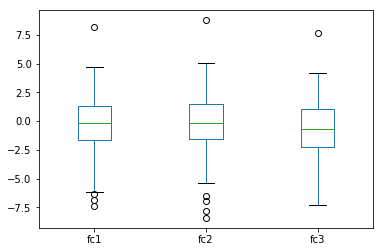

In [39]:
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1
Gene_id,,,,,,,,
Tb927.10.11980,QA-SNARE protein putative,306.783755,306.783755,306.783755,0.803362,7.751033,6.472274,56546880
Tb927.5.5420,"Variant Surface Glycoprotein, putative",25.917050,25.917050,25.917050,0.774663,6.694228,5.351816,5124580
Tb927.11.7370,"haloacid dehalogenase hydrolase, putative",18.979953,18.979953,9.624249,0.855053,6.447778,5.271702,2982880
Tb927.3.3670,Triple RNA binding domain protein 3,9.624249,9.624249,7.255840,0.772146,6.190724,4.775756,1730280
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",7.255840,5.297019,2.805345,0.977495,6.095483,4.590351,1424780
Tb11.v5.0750,"dual specificity protein phosphatase, putative",6.085771,6.085771,6.085771,0.761995,6.065617,4.603209,1341980
Tb927.11.11750,"membrane-bound acid phosphatase, putative",5.297019,7.255840,3.177849,1.074048,5.945326,4.714874,1060590
Tb927.8.5010,Paraflagellar rod protein 2-5,3.177849,2.411501,5.297019,1.255128,6.057552,4.595165,1122580
Tb09.v4.0174,"variant surface glycoprotein (VSG, pseudogene)...",2.805345,3.177849,2.411501,0.761281,5.568225,4.153266,548900


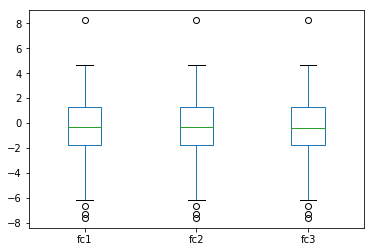

In [40]:
df[['fc1','fc2','fc3']]=quantileNormalize(df[['fc1','fc2','fc3']])
np.log2(df[['fc1','fc2','fc3']]).plot(kind='box')
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1']].sort_values(['fc1','log10_intensity'], ascending=False).head(10)

In [41]:
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
onesample_results = ttest_ind(df[['fc1','fc2','fc2']].T, 
                              np.ones((3,df.shape[0])))
df['pvalues']=onesample_results.pvalue
df[['Gene_desc','fc1',
     'fc2','fc3',
     'log10_score',
     'log10_intensity',
     'log10_iBAQ',
     'Intensity 1','pvalues']].sort_values(['fc1', 'log10_intensity'], ascending=False).head(10)

,Gene_desc,fc1,fc2,fc3,log10_score,log10_intensity,log10_iBAQ,Intensity 1,pvalues
Gene_id,,,,,,,,,
Tb927.10.11980,QA-SNARE protein putative,306.783755,306.783755,306.783755,0.803362,7.751033,6.472274,56546880,0.000000
Tb927.5.5420,"Variant Surface Glycoprotein, putative",25.917050,25.917050,25.917050,0.774663,6.694228,5.351816,5124580,0.000000
Tb927.11.7370,"haloacid dehalogenase hydrolase, putative",18.979953,18.979953,9.624249,0.855053,6.447778,5.271702,2982880,0.000000
Tb927.3.3670,Triple RNA binding domain protein 3,9.624249,9.624249,7.255840,0.772146,6.190724,4.775756,1730280,0.000000
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",7.255840,5.297019,2.805345,0.977495,6.095483,4.590351,1424780,0.001624
Tb11.v5.0750,"dual specificity protein phosphatase, putative",6.085771,6.085771,6.085771,0.761995,6.065617,4.603209,1341980,0.000000
Tb927.11.11750,"membrane-bound acid phosphatase, putative",5.297019,7.255840,3.177849,1.074048,5.945326,4.714874,1060590,0.001013
Tb927.8.5010,Paraflagellar rod protein 2-5,3.177849,2.411501,5.297019,1.255128,6.057552,4.595165,1122580,0.002848
Tb09.v4.0174,"variant surface glycoprotein (VSG, pseudogene)...",2.805345,3.177849,2.411501,0.761281,5.568225,4.153266,548900,0.000078


In [42]:
df['mean']=df[['fc1','fc2','fc2']].mean(axis=1)

In [43]:
df['log_mean']=np.log2(df['mean'])
df['log_pvalues']=-np.log10(df['pvalues']+0.0001)
df['pvalues']=onesample_results.pvalue
df[['Gene_desc',
     'log_pvalues',
    'log_mean',
   'log10_intensity']].sort_values(['log_mean',
                              'log_pvalues'], ascending=False).head(20)

,Gene_desc,log_pvalues,log_mean,log10_intensity
Gene_id,,,,
Tb927.10.11980,QA-SNARE protein putative,4.000000,8.261078,7.751033
Tb927.5.5420,"Variant Surface Glycoprotein, putative",4.000000,4.695830,6.694228
Tb927.11.7370,"haloacid dehalogenase hydrolase, putative",4.000000,4.246404,6.447778
Tb927.3.3670,Triple RNA binding domain protein 3,4.000000,3.266674,6.190724
Tb927.11.11750,"membrane-bound acid phosphatase, putative",2.953457,2.723100,5.945326
Tb11.v5.0750,"dual specificity protein phosphatase, putative",4.000000,2.605440,6.065617
Tb927.6.1880,"aspartyl-tRNA synthetase, putative",2.763574,2.572880,6.095483
Tb09.v4.0174,"variant surface glycoprotein (VSG, pseudogene)...",3.748941,1.610549,5.568225
Tb927.11.6970,NADH-cytochrome b5 reductase-like protein,3.497696,1.419034,5.494141


In [44]:
from adjustText import adjust_text

                log_mean  log10_intensity
Gene_id                                  
Tb927.11.11750    2.7231         5.945326


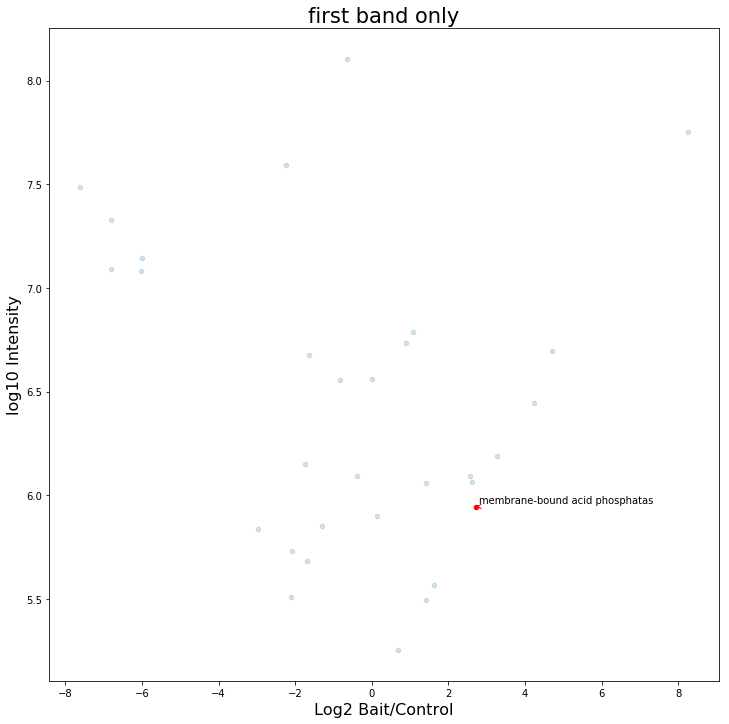

In [47]:
fig,ax=plt.subplots(figsize=(12,12))
df.plot(x='log_mean', y='log10_intensity',kind='scatter', ax=ax,alpha=0.2)


ids = ['Tb927.11.11750']

select = df.loc[ids]#df[(df['log_mean']>5)&(df['log10_intensity']>6.5)]
select.plot(x='log_mean', y='log10_intensity',kind='scatter', c='r', ax=ax)
print(select[['log_mean','log10_intensity']].head())
texts = [plt.text(select.loc[i]['log_mean'], 
                  select.loc[i]['log10_intensity'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30]
                 ) for i in select.index.values]

adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))
plt.xlabel('Log2 Bait/Control',size=16)
plt.ylabel('log10 Intensity',size=16)
plt.title('first band only',size=21)
plt.show()